In [1]:
from typing import Union
import scanpy as sc
import anndata
import logging
import os
import numpy as np
import pandas as pd
import json
import sys
# import scanpy.external as sce
logging.basicConfig(level=logging.INFO)
import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold

from scipy import stats
import pingouin

import matplotlib.pyplot as plt
import seaborn as sns

import umap

# from PySpots.fish_helpers import *
from dredFISH.Analysis import basicu
from dredFISH.Analysis import regu
from dredFISH.Analysis import celltypeu
from dredFISH.Analysis import evalu
from dredFISH.Analysis import TissueGraph as tgh

import importlib
importlib.reload(tgh)
importlib.reload(celltypeu)
importlib.reload(evalu)
importlib.reload(basicu)
sc.set_figure_params(figsize=(7, 7))

In [2]:
logging.info('hi')

INFO:root:hi


In [3]:
def anova_eta2(ydata, ylabels):
    """ydata = (nsample, nvariable)
    ylabel = (nsample,)
    """
    gmean = ydata.mean(axis=0)

    SSt = np.power((ydata-gmean), 2).sum(axis=0)
    SSb = np.zeros(ydata.shape[1])

    clsts = np.unique(ylabels)
    # Yclsts = []
    for clst in clsts:
        cond = ylabels==clst
        yclst = ydata[cond]
        lmean = yclst.mean(axis=0)
        ln = len(yclst)

        # for each gene
        SSb += np.power((lmean-gmean), 2)*ln

    # get eta2
    assert np.all(SSb<=SSt)
    eta2 = SSb/(SSt+1e-6)
    return eta2, SSt, SSb

# file paths and load data

In [4]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

# allen data
scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'
# scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_10x_ctxhippo_a_DPNMF_matrix.h5ad'

scrna_genes_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_matrix.h5ad'

# DPNMF matrix 
pmat_path = f'{dat_dir}dpnmf.csv' 


In [5]:
%%time
# allen scrna matrix
ref_data = anndata.read_h5ad(scrna_path)
# print(ref_data)
ref_data_genes = anndata.read_h5ad(scrna_genes_path) # library size normed (no log)




CPU times: user 819 ms, sys: 1.56 s, total: 2.38 s
Wall time: 7.08 s


In [6]:
pmat = pd.read_csv(pmat_path, index_col=0).loc[ref_data_genes.var.index]
pmatf = (pmat/pmat.sum(axis=0))
print(pmat.shape)
print(pmatf.shape)
pmat_maxw = pmat.max(axis=1)
pmatf_maxw = pmatf.max(axis=1)

(5576, 24)
(5576, 24)


In [7]:
# prepare
ref_data.obs = ref_data.obs.rename(columns={
    'class_label': 'Level_1_class_label', 
    'neighborhood_label': 'Level_2_neighborhood_label', 
    'subclass_label': 'Level_3_subclass_label', 
    # 'supertype_label', 
    'cluster_label': 'Level_5_cluster_label', 
})

celltype_levels = np.sort(ref_data.obs.filter(regex=r'^Level_[0-9]', axis=1).columns.values)
print(celltype_levels)

levels = celltype_levels[:3]      
X_refdata = np.array(ref_data.X)

['Level_1_class_label' 'Level_2_neighborhood_label'
 'Level_3_subclass_label' 'Level_5_cluster_label']


In [8]:
# ref_data.obs.groupby('Level_1_class_label').size()
print(ref_data)
print(ref_data_genes)

AnnData object with n_obs × n_vars = 73347 × 24
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label',

# Run gene reconstruction
- find neighbors using 24 bits
- reconstruct genes in high-dimensions based on those neighbors

- what gene set to use: 5818 genes involved (5576 overlap with scRNA SS)

In [9]:
%%time
# randomly split cells into train (lowdim, highdim) and test (lowdim, highdim to be predicted)
X = ref_data.X.copy()
yraw = np.array(ref_data_genes.X.todense()).copy()

X = basicu.zscore(X, axis=0)
y = np.log10(yraw+1)
# y.data = np.log10(y.data+1)

print(X.shape, y.shape)

(73347, 24) (73347, 5576)
CPU times: user 7.09 s, sys: 6.8 s, total: 13.9 s
Wall time: 13.9 s


# clusterings

In [10]:
# adata = anndata.AnnData(X=y, obs=ref_data.obs)
# sc.tl.pca(adata, svd_solver='arpack') # with or without PCs
# sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

In [11]:
# # resolutions = [1, 10, 100]#, 1000, 10000]
# # resolutions = [1000, 10000]
# # resolutions = [200, 500, 2000, 5000]
# resolutions = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

# adata.uns['resolutions'] = np.array(resolutions)

# for r in tqdm.tqdm(resolutions):
#     col = f'leiden_r{r}'
#     sc.tl.leiden(adata, resolution=r, key_added=col)
#     eta2, SSt, SSb = anova_eta2(y, adata.obs[col].values)
#     adata.var[f'eta2_{col}'] = eta2
#     adata.var[f'SSt_{col}'] = SSt
#     adata.var[f'SSb_{col}'] = SSb 
    
#     nclst = len(np.unique(adata.obs[col].values))
#     print(r, nclst)
    
#     # break

In [12]:
# %%time
# # save results (adata res)
# output = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_eta2.h5ad'
# adata.write(output)

In [13]:
# eta results -- used below; naming is bad for historical reasons
eta2_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_eta2.h5ad'
adata = anndata.read_h5ad(eta2_path)
adata

AnnData object with n_obs × n_vars = 73347 × 5576
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label

# estimate poisson noise

In [14]:
ref_data_genes

AnnData object with n_obs × n_vars = 73347 × 5576
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label', 'subclass_color', 'neighborhood_id', 'neighborhood_label', 'neighborhood_color', 'class_order', 'class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label', 'cell_type_alias_label', 'cel

In [15]:
yraw

array([[ 39.60121  ,  19.800606 ,   0.       , ...,   3.168097 ,
         79.99445  ,  41.977287 ],
       [ 62.552402 ,  45.318577 ,   0.       , ...,  16.595535 ,
        117.44533  ,  30.63791  ],
       [ 64.12973  , 100.607185 ,   0.       , ...,   1.7650384,
        213.56964  ,  51.77446  ],
       ...,
       [ 14.4886   , 182.1424   ,   0.       , ...,  28.9772   ,
         57.9544   ,   0.       ],
       [ 32.29245  ,  90.07894  ,   0.       , ...,  16.996027 ,
         54.387287 ,   6.798411 ],
       [  7.8754406, 163.80917  ,   0.       , ...,  48.827732 ,
         33.07685  , 127.58214  ]], dtype=float32)

In [47]:
ymean = yraw.mean(axis=0)
ystd = yraw.std(axis=0)

ymeanlog = y.mean(axis=0)
ystdlog = y.std(axis=0)
# yraw.sum(axis=1)
yp=adata.var['eta2_leiden_r1'].values

/tmp/ipykernel_1717147/4089630149.py:2: RuntimeWarning:

invalid value encountered in true_divide



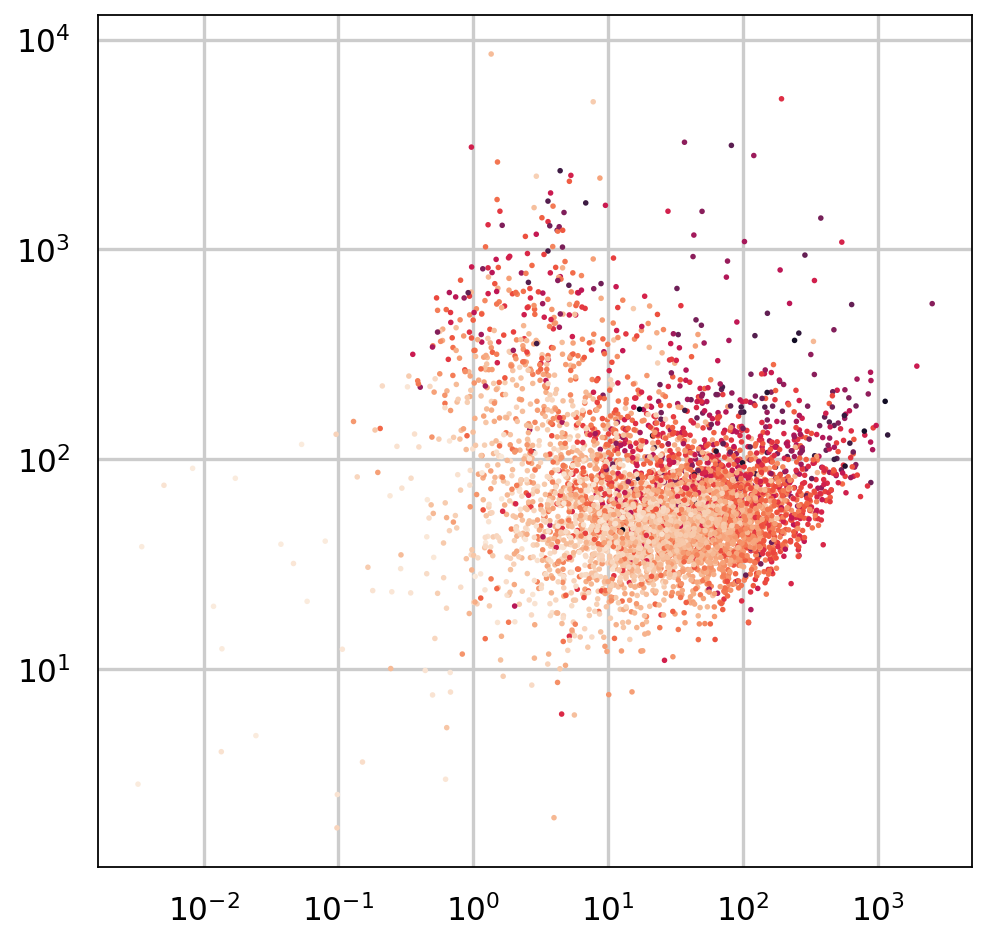

In [17]:
fig, ax = plt.subplots()
ax.scatter(ymean, np.power(ystd, 2)/ymean, c=yp, s=1, cmap='rocket_r')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

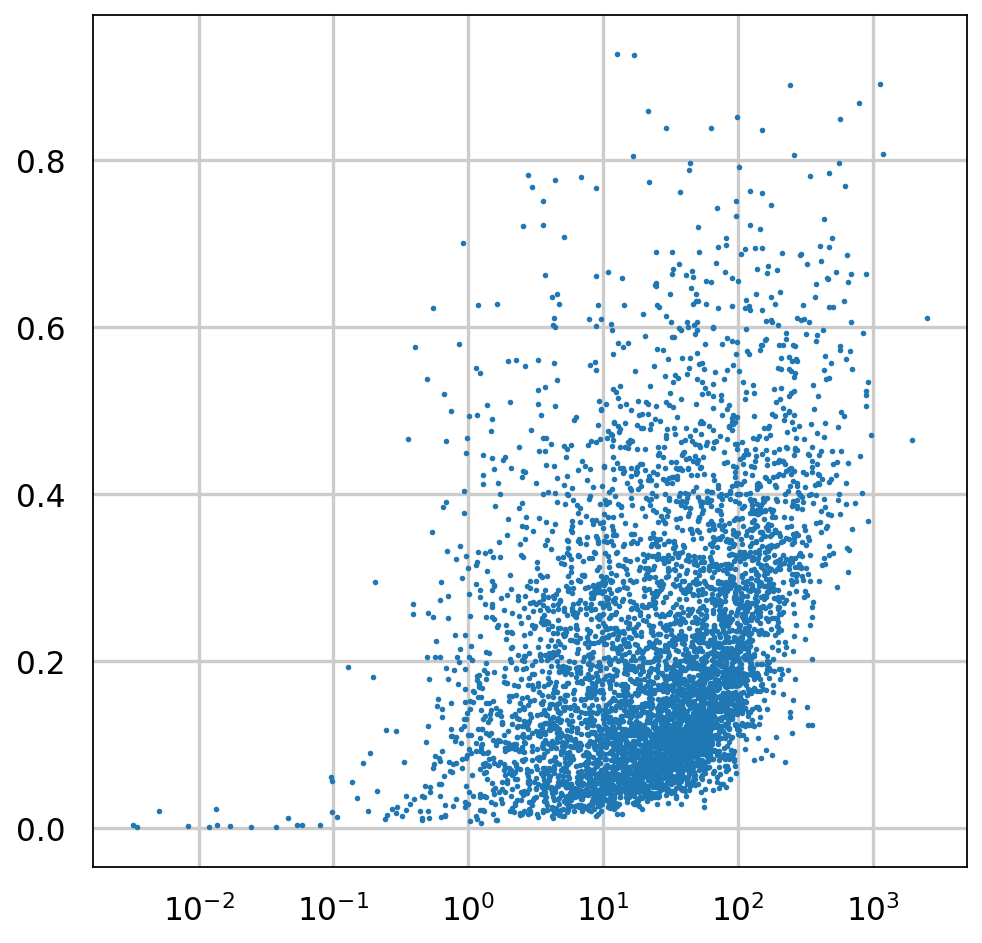

In [18]:
fig, ax = plt.subplots()
ax.scatter(ymean, yp, s=1)
ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

/tmp/ipykernel_1717147/3338175734.py:2: RuntimeWarning:

invalid value encountered in true_divide



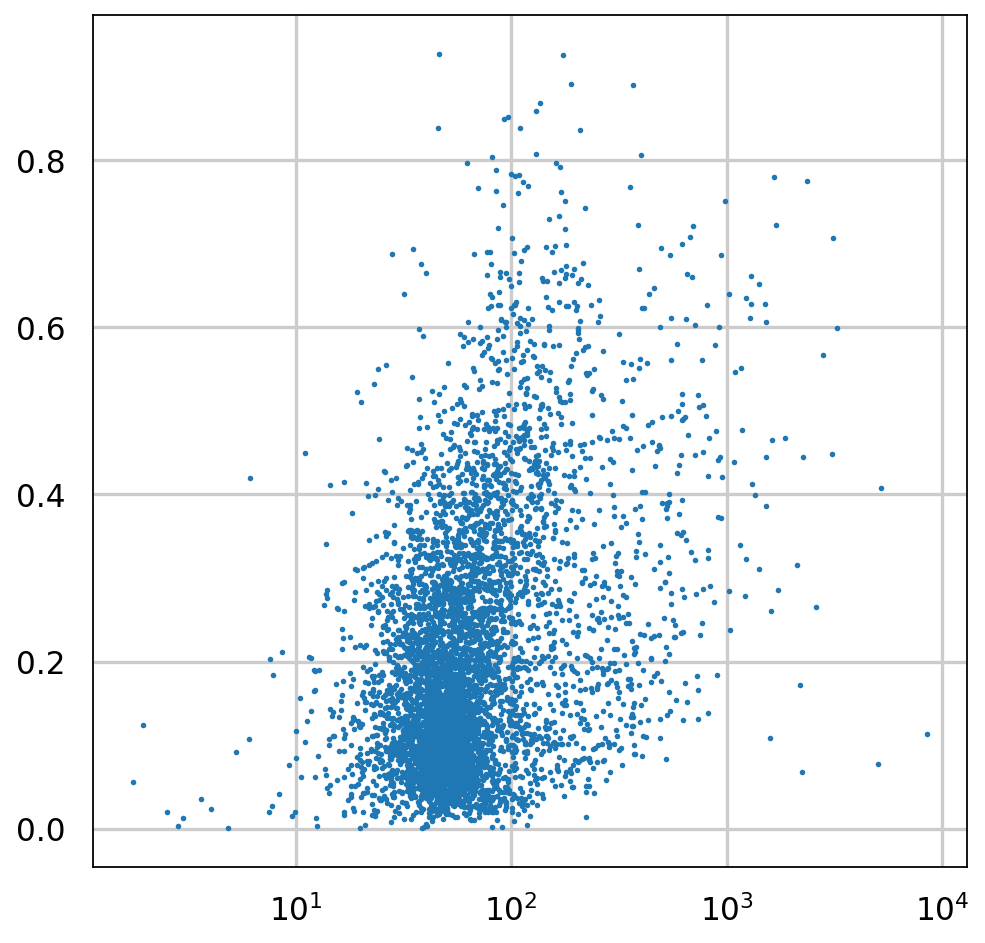

In [19]:
fig, ax = plt.subplots()
ax.scatter(np.power(ystd, 2)/ymean, yp, s=1)
ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

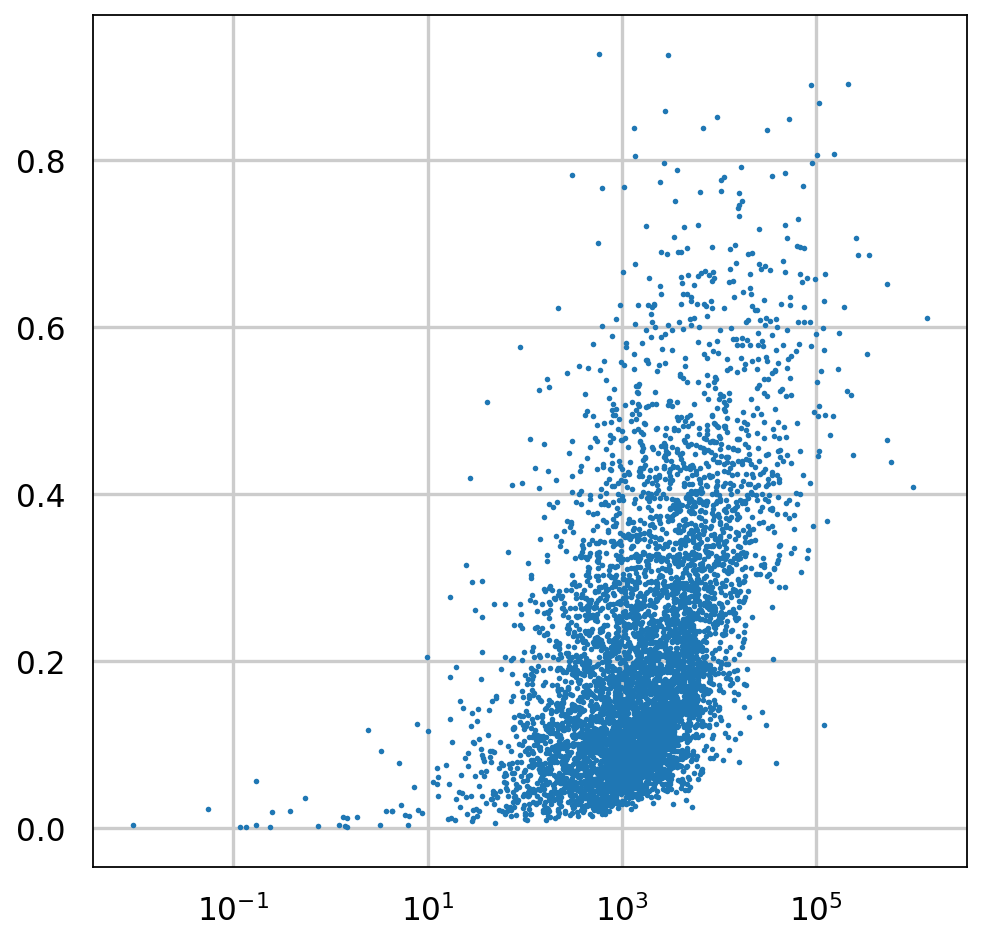

In [20]:
fig, ax = plt.subplots()
ax.scatter(np.power(ystd, 2), yp, s=1)
ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

/tmp/ipykernel_1717147/309400532.py:4: RuntimeWarning:

invalid value encountered in true_divide

/tmp/ipykernel_1717147/309400532.py:9: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



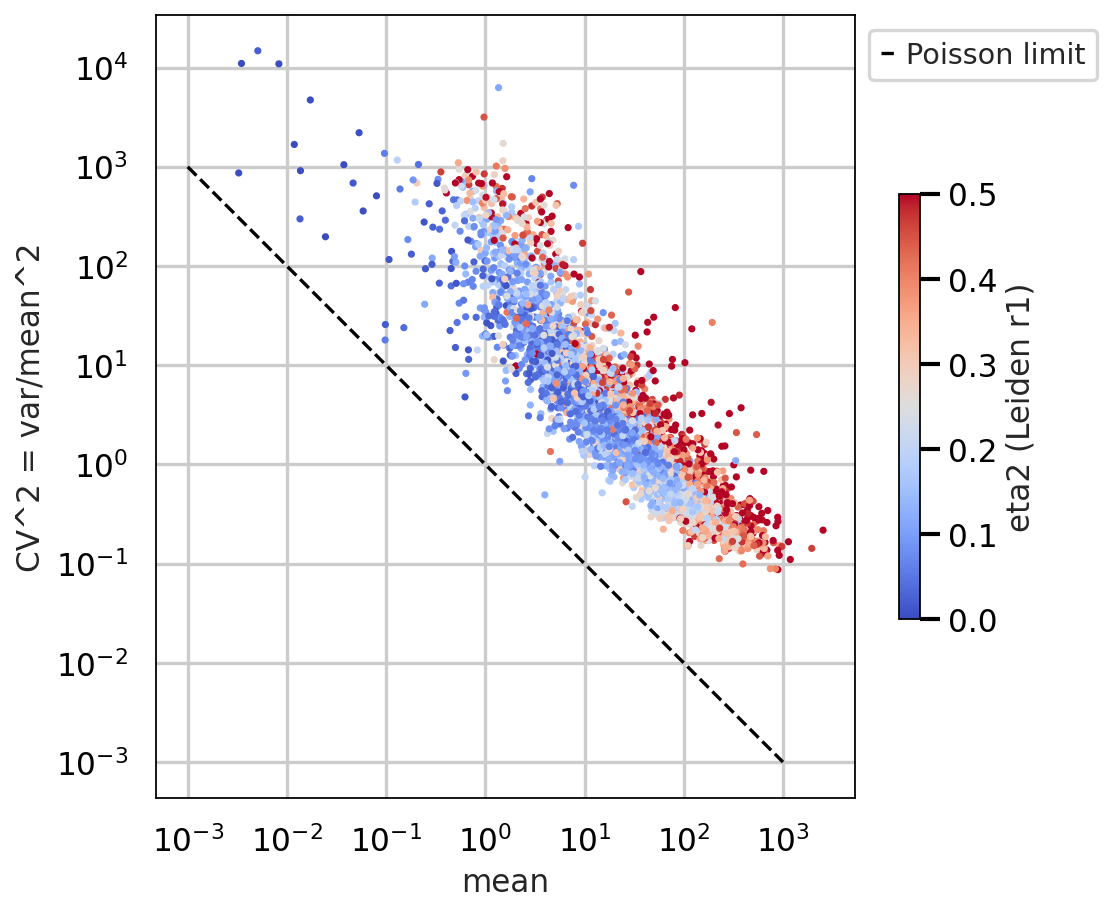

In [21]:
basis = np.array([1e-3, 0.01, 0.1, 1, 10, 100, 1e3])

fig, ax = plt.subplots()
g = ax.scatter(ymean, np.power(ystd/ymean, 2), c=yp, s=3, cmap='coolwarm', 
               vmin=0, 
               vmax=.5,
              )
ax.plot(basis, 1/basis, '--k', label='Poisson limit')
fig.colorbar(g, label='eta2 (Leiden r1)', shrink=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal')
ax.set_xticks(basis)

ax.set_xlabel('mean')
ax.set_ylabel('CV^2 = var/mean^2')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

/tmp/ipykernel_1717147/2859231409.py:4: RuntimeWarning:

invalid value encountered in true_divide

/tmp/ipykernel_1717147/2859231409.py:9: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



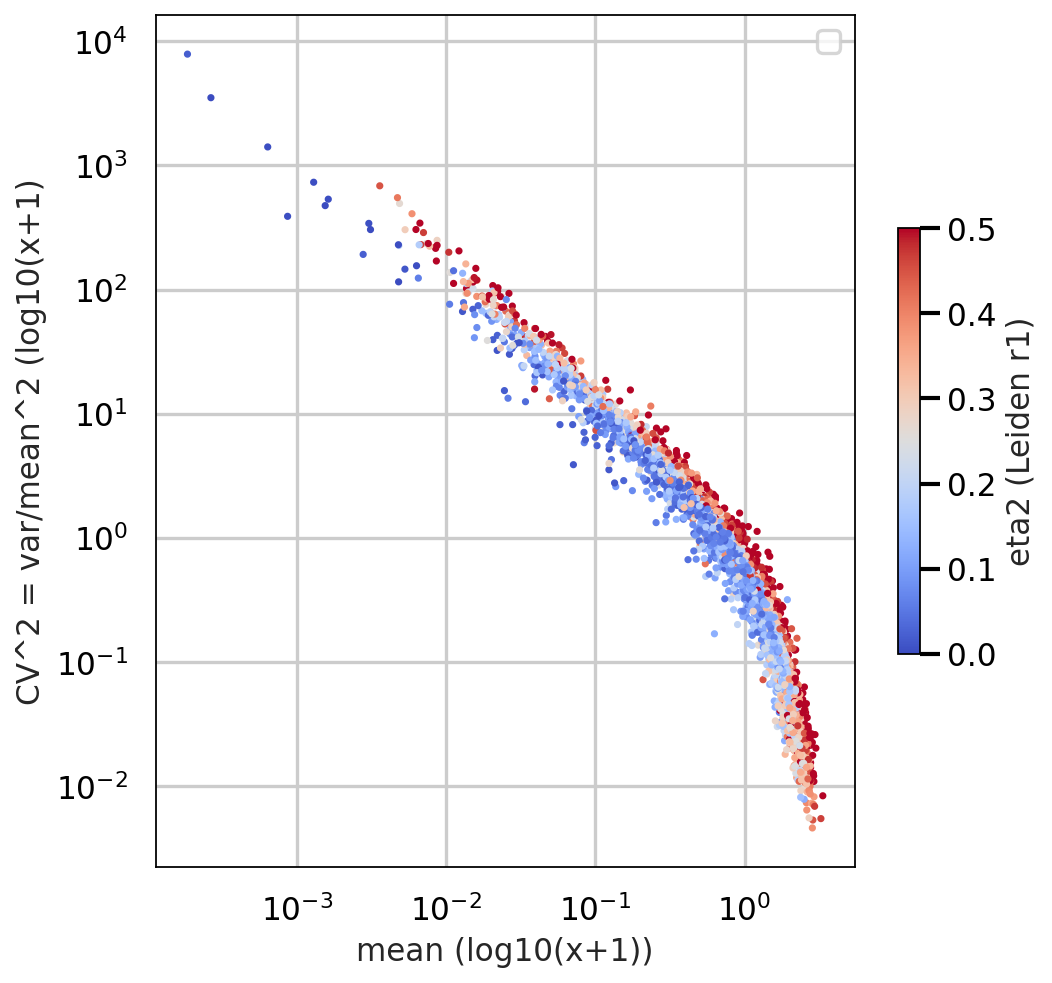

In [22]:
basis = np.array([1e-3, 0.01, 0.1, 1, 10, 100, 1e3])

fig, ax = plt.subplots()
g = ax.scatter(ymeanlog, np.power(ystdlog/ymeanlog, 2), c=yp, s=3, cmap='coolwarm', 
               vmin=0, 
               vmax=.5,
              )
# ax.plot(basis, 1/basis, '--k', label='Poisson limit')
fig.colorbar(g, label='eta2 (Leiden r1)', shrink=0.5)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('mean (log10(x+1))')
ax.set_ylabel('CV^2 = var/mean^2 (log10(x+1)')
ax.legend()
plt.show()

In [23]:
def cv2(vec):
    """
    """
    mean = np.mean(vec)
    std = np.std(vec)
    return (std/mean)**2

In [24]:
cv2_basis = []

logmean_vec = []
logvar_vec = []
logcv2_vec = []
for lmd in basis:
    rand = np.random.poisson(lam=lmd, size=int(1e5))
    logrand = np.log10(rand+1)
    logcv2 = cv2(logrand)
    logmean = np.mean(logrand)
    logvar = np.std(logrand)**2
    
    logmean_vec.append(logmean)
    logvar_vec.append(logvar)
    logcv2_vec.append(logcv2)
    
    cv2_basis.append(cv2(rand))
    print(rand.shape, cv2(rand))

(100000,) 960.5384615384619
(100000,) 104.80346760219213
(100000,) 9.960233117525878
(100000,) 1.0054963083155009
(100000,) 0.09985079939879818
(100000,) 0.010054041641543698
(100000,) 0.0009959801311391775


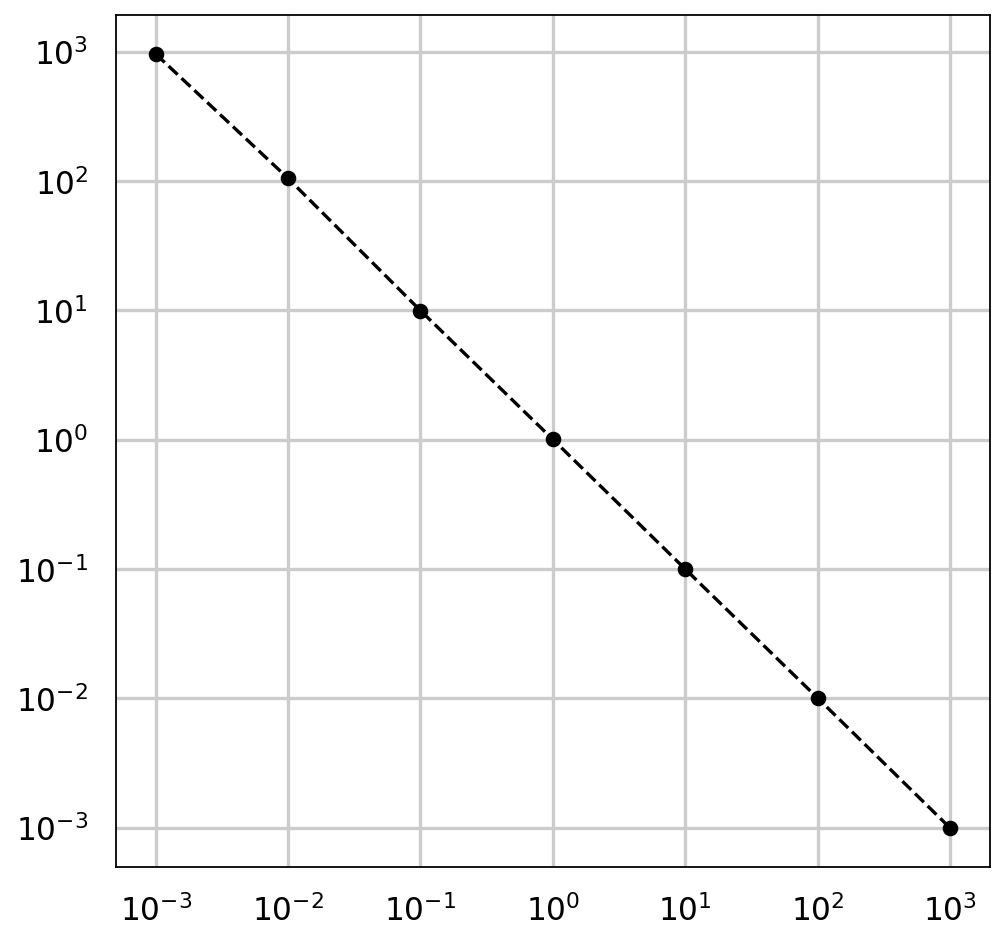

In [25]:
plt.plot(basis, cv2_basis, '--ok')
plt.xscale('log')
plt.yscale('log')

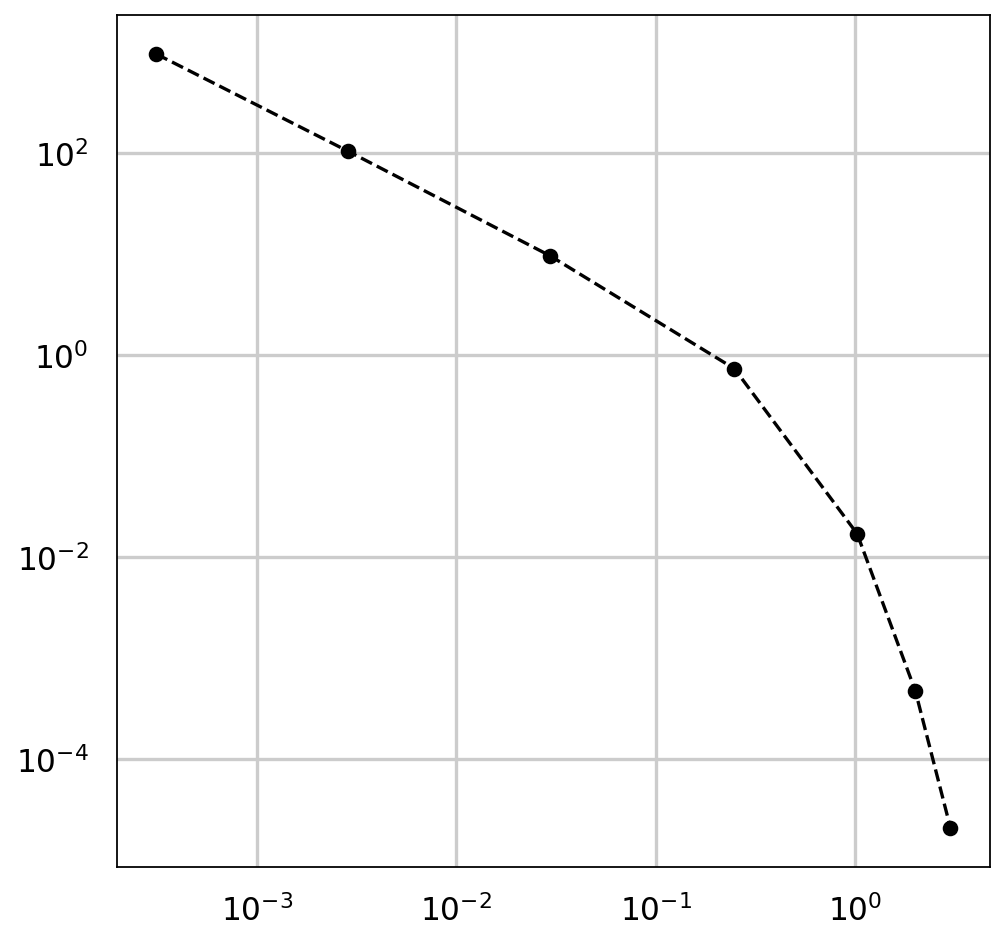

In [26]:
plt.plot(logmean_vec, logcv2_vec, '--ok')
plt.xscale('log')
plt.yscale('log')

/tmp/ipykernel_1717147/2136304173.py:5: RuntimeWarning:

invalid value encountered in true_divide

/tmp/ipykernel_1717147/2136304173.py:9: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



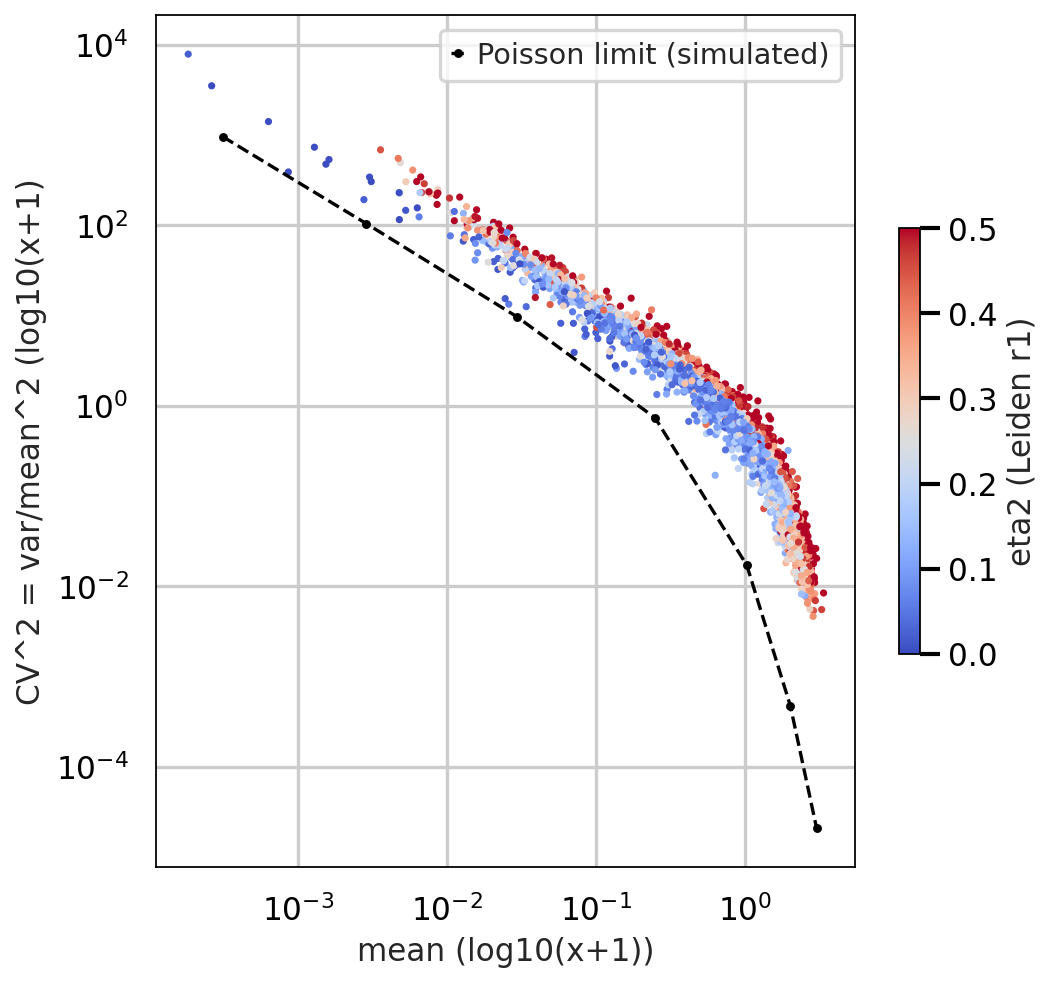

In [27]:
basis = np.array([1e-3, 0.01, 0.1, 1, 10, 100, 1e3])

fig, ax = plt.subplots()
ax.plot(logmean_vec, logcv2_vec, '--ok', markersize=3, label='Poisson limit (simulated)')
g = ax.scatter(ymeanlog, np.power(ystdlog/ymeanlog, 2), c=yp, s=3, cmap='coolwarm', 
               vmin=0, 
               vmax=.5,
              )
fig.colorbar(g, label='eta2 (Leiden r1)', shrink=0.5)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('mean (log10(x+1))')
ax.set_ylabel('CV^2 = var/mean^2 (log10(x+1)')
ax.legend()
plt.show()

In [28]:
expmean = ymeanlog
expcv2 = np.interp(expmean, logmean_vec, logcv2_vec)
expvar = expcv2*np.power(expmean,2)
expvarratio = expvar/np.power(ystdlog,2)

/tmp/ipykernel_1717147/2209947445.py:4: RuntimeWarning:

invalid value encountered in true_divide



In [48]:
10*ymean.sum()/np.power(ystd, 2).sum()

0.10118161743047815

In [36]:
overall_poisson_noise_ratio = expvar.sum()/np.power(ystdlog, 2).sum()
overall_poisson_noise_ratio

0.14613175393955022

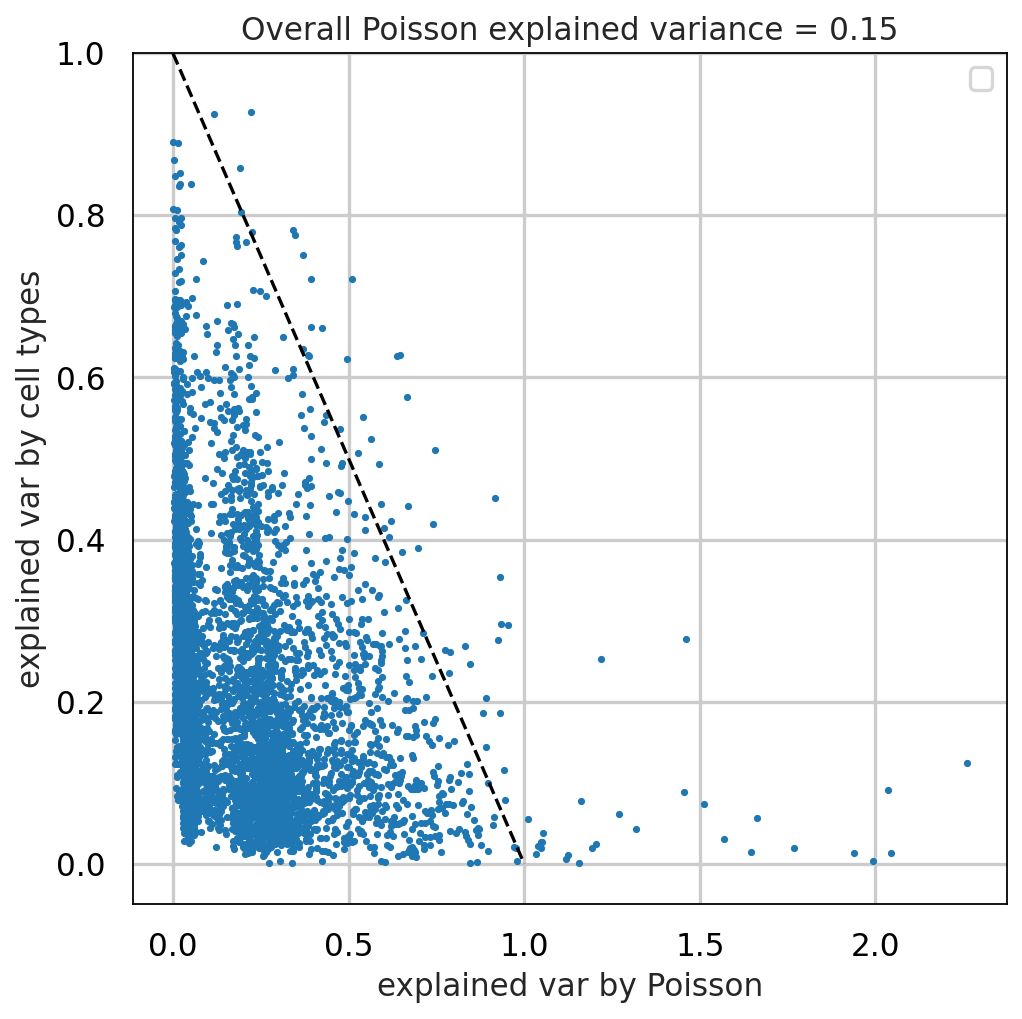

In [38]:
basis = np.array([1e-3, 0.01, 0.1, 1, 10, 100, 1e3])

fig, ax = plt.subplots()
# ax.plot(logmean_vec, logcv2_vec, '--ok', markersize=3, label='Poisson limit (simulated)')
g = ax.scatter(expvarratio, 
               yp, 
               s=3, 
               # cmap='coolwarm', 
               # vmin=0, 
               # vmax=.5,
              )

# fig.colorbar(g, label='eta2 (Leiden r1)', shrink=0.5)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(xmax=1)
ax.plot([0,1], [1,0], '--k')

ax.set_ylim(ymax=1)

ax.set_xlabel('explained var by Poisson')
ax.set_ylabel('explained var by cell types')
ax.set_title(f"Overall Poisson explained variance = {overall_poisson_noise_ratio:.2g}")
ax.legend()
plt.show()

In [34]:
# 

0.14613175393955022

In [39]:
expvar

array([0.01613647, 0.00188954, 0.112632  , ..., 0.15127964, 0.01930882,
       0.05671446])

In [40]:
np.power(ystdlog, 2)

array([0.37181073, 0.13094048, 0.15776491, ..., 0.37580857, 0.34878698,
       0.50943506], dtype=float32)